# Part 1: Zero-Shot Classification on STL-10

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224,224)),  # CLIP expects 224x224
    transforms.ToTensor(),
])

test_dataset = datasets.STL10(root="./data", split="test", download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 2.64G/2.64G [00:43<00:00, 61.3MB/s]


In [3]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-do5u7g4o
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-do5u7g4o
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=ce0bf563153553d9292828ee24ecb48d95b4b6a3b59cb04a9c16cf7b2c709cc4
  Stored in directory: /tmp/pip-ephem-wheel-cache-1kfkqy5s/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 145MiB/s]


In [4]:
import torch.nn.functional as F

# STL-10 class labels
labels = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]

# Define prompt strategies
prompt_strategies = {
    "plain": labels,
    "a_photo_of": [f"a photo of a {c}" for c in labels],
    "descriptive": [f"a high-resolution image of a {c}, taken outdoors" for c in labels]
}

results = {}

for strategy_name, prompts in prompt_strategies.items():
    text_tokens = clip.tokenize(prompts).to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = image_features @ text_features.T
            preds = logits.argmax(dim=-1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    acc = correct / total
    results[strategy_name] = acc
    print(f"Zero-shot accuracy using '{strategy_name}' prompts: {acc:.4f}")


Zero-shot accuracy using 'plain' prompts: 0.9389
Zero-shot accuracy using 'a_photo_of' prompts: 0.9485
Zero-shot accuracy using 'descriptive' prompts: 0.9491


# Part 2: Exploring the Modality Gap

In [5]:
import numpy as np

num_samples = 100
images_list, labels_list = [], []
for i, (images, targets) in enumerate(test_loader):
    images_list.append(images)
    labels_list.append(targets)
    if len(images_list)*images.size(0) >= num_samples:
        break

images_small = torch.cat(images_list, dim=0)[:num_samples].to(device)
labels_small = torch.cat(labels_list, dim=0)[:num_samples]

# Encode images
with torch.no_grad():
    image_emb = model.encode_image(images_small)
    image_emb /= image_emb.norm(dim=-1, keepdim=True)

# Encode corresponding text labels
prompts = [f"a photo of a {labels[i]}" for i in labels_small]
text_tokens = clip.tokenize(prompts).to(device)
with torch.no_grad():
    text_emb = model.encode_text(text_tokens)
    text_emb /= text_emb.norm(dim=-1, keepdim=True)


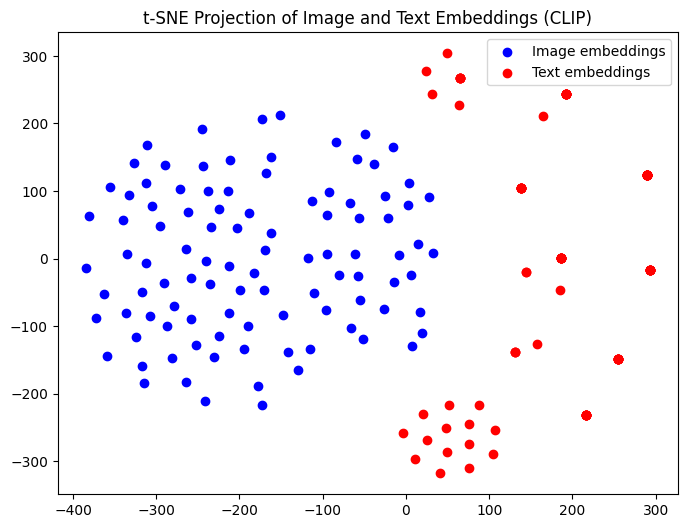

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
combined_emb = torch.cat([image_emb, text_emb], dim=0).cpu().numpy()
tsne_proj = tsne.fit_transform(combined_emb)

image_proj = tsne_proj[:num_samples]
text_proj = tsne_proj[num_samples:]

plt.figure(figsize=(8,6))
plt.scatter(image_proj[:,0], image_proj[:,1], c='blue', label='Image embeddings')
plt.scatter(text_proj[:,0], text_proj[:,1], c='red', label='Text embeddings')
plt.legend()
plt.title("t-SNE Projection of Image and Text Embeddings (CLIP)")
plt.show()


# Part 3: Bridging the Modality Gap with Orthogonal Procrustes

In [7]:
from scipy.linalg import orthogonal_procrustes

# Compute rotation matrix R
X = image_emb.cpu().numpy()
Y = text_emb.cpu().numpy()
R, scale = orthogonal_procrustes(X, Y)

# Apply rotation
X_aligned = X @ R


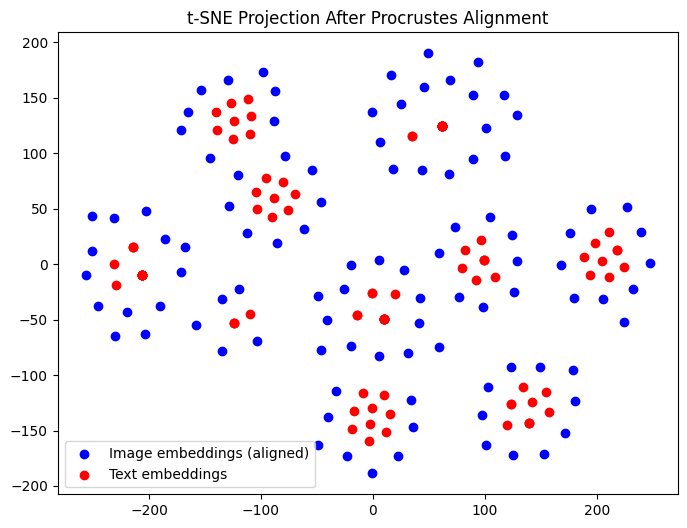

In [8]:
tsne_aligned = TSNE(n_components=2, random_state=42)
combined_aligned = np.vstack([X_aligned, Y])
tsne_proj_aligned = tsne_aligned.fit_transform(combined_aligned)

image_proj_aligned = tsne_proj_aligned[:num_samples]
text_proj_aligned = tsne_proj_aligned[num_samples:]

plt.figure(figsize=(8,6))
plt.scatter(image_proj_aligned[:,0], image_proj_aligned[:,1], c='blue', label='Image embeddings (aligned)')
plt.scatter(text_proj_aligned[:,0], text_proj_aligned[:,1], c='red', label='Text embeddings')
plt.legend()
plt.title("t-SNE Projection After Procrustes Alignment")
plt.show()


In [9]:
aligned_results = {}

with torch.no_grad():
    for strategy_name, prompts in prompt_strategies.items():
        correct = 0
        total = 0

        # Encode text once per strategy (aligned dtype)
        text_tokens = clip.tokenize(prompts).to(device)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.float()

        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)

            # Encode + normalize images
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.float()

            # Similarity
            logits = image_features @ text_features.T
            preds = logits.argmax(dim=-1)

            correct += (preds == targets).sum().item()
            total += targets.size(0)

        acc = correct / total
        aligned_results[strategy_name] = acc
        print(f"Zero-shot accuracy AFTER alignment using '{strategy_name}': {acc:.4f}")


Zero-shot accuracy AFTER alignment using 'plain': 0.9389
Zero-shot accuracy AFTER alignment using 'a_photo_of': 0.9485
Zero-shot accuracy AFTER alignment using 'descriptive': 0.9490
